## Tema

#### Geografía


## Título de proyecto

Proyecto de Machine Learning: Clasificación de superficies terrestres reconocidas por vía satelital



## Descripción

En este proyecto se diseñan diversos modelos de inteligencia artificial capaces de reconocer imágenes tomadas por vía satelital, sobre la superficie terrestre, y clasificarlas en grupos siguiendo los criterios de análisis exploratorio, aprendizaje automático (machine learning), aprendizaje profundo (deep learning), visualización de datos y diseño experimental. 

## Datasets

Link de Dataset de partida: http://madm.dfki.de/downloads

El dataset que se trabaja en este proyecto contiene 27000 imágenes terrestres y geolocalizables del satélite Sentinel-2, de acceso público y aportadas por el programa Europeo de observación Copernicus.


In [1]:
#Primero se ejecutan las importaciones a las librerías con las que se trabaja el archivo main.ipynb.

import numpy as np
import pandas as pd
import random
import seaborn as sns

import matplotlib.pyplot as plt
from utils.mysql_tb import MySQL, connect_mysql

import utils.visualization_tb as vi
import utils.mining_data_tb as mn
import utils.folders_tb as fol
import utils.models_tb as mo
from utils.mysql_tb import MySQL, connect_mysql

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import os
import shutil

from sqlalchemy import create_engine

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_visualizer import visualizer 


In [3]:
#Para este proyecto se comprueba que se ha utilizado la versión de tensorflow 2.5.0

print("Versión de tensorflow:",tf.__version__)

Versión de tensorflow: 2.5.0


In [5]:
#Se asignan los parámetros base con los que se van a ejecutar los parámetros de visualización.

vi.sns_gstyle()
%matplotlib inline

## Procesado de carpetas y archivos de descarga

Si un usuario externo quiere ejecutar el proyecto, se le recomienda omitir la ejecución de las celdas que hay en esta sección a continuación

In [2]:
#El dataset con el que se trabaja en este proyecto se encuentra en "data/downloads/sentinel_2".

ds_dir = ".." + os.sep + "data" + os.sep + "downloads" + os.sep + "sentinel_2"

In [7]:
#Lo primero que se va a hacer es, desde la ruta del archivo descargado, importar los nombres de las distintas carpetas que clasifican las imágenes descargadas. 

#AVISO: Esta celda solo tiene que ser ejecutada una única vez. En este caso de trabajo, ya ha sido ejecutada, por lo que no se recomienda volver a ejecutar para su óptima visualización, no obstante, no generará cambios en el resto del proyecto ya que genera una variable con la que no se va a trabajar.

os.listdir(ds_dir)

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [8]:
#Como las carpetas corresponden con las clases que se van a trabajar, se les cambia el nombre a español. De esta manera, las visualizaciones serán más comprensibles para el público.

#Para ello se elabora una traducción manual de las palabras que definen las carpetas.

folder_names_list = ['cultivo_transitorio','bosque','vegetacion_herbacea', 'carretera', 'industrial', 'pasto', 'cultivo_permanente', 'residencial','rio','lago_mar']

#AVISO: Esta celda solo tiene que ser ejecutada una única vez. En este caso de trabajo, ya ha sido ejecutada, por lo que no se recomienda volver a ejecutar para su óptima visualización. Si se vuelve a ejecutar, dará lugar a un error que no interferirá en los resultados ya que la función no hará ningun cambio sobre el contenido con el que se trabaja.

fol.rename_files(ds_dir, fol_names = folder_names_list)

Todos los nombres han sido sobreescritos exitosamente

Ejemplo resultante: bosque


In [7]:
#Se analiza los nombres de los archivos contenidos en las diferentes carpetas.

#AVISO: Esta celda solo tiene que ser ejecutada una única vez. En este caso de trabajo, ya ha sido ejecutada, por lo que no se recomienda volver a ejecutar para su óptima visualización, no obstante, no generará cambios en el resto del proyecto ya que genera una variable con la que no se va a trabajar.

fol.show_filenames(ds_dir)

Diez primeros archivos dentro de la carpeta bosque:

['Forest_1.jpg', 'Forest_10.jpg', 'Forest_100.jpg', 'Forest_1000.jpg', 'Forest_1001.jpg', 'Forest_1002.jpg', 'Forest_1003.jpg', 'Forest_1004.jpg', 'Forest_1005.jpg', 'Forest_1006.jpg']


Diez primeros archivos dentro de la carpeta carretera:

['Highway_1.jpg', 'Highway_10.jpg', 'Highway_100.jpg', 'Highway_1000.jpg', 'Highway_1001.jpg', 'Highway_1002.jpg', 'Highway_1003.jpg', 'Highway_1004.jpg', 'Highway_1005.jpg', 'Highway_1006.jpg']


Diez primeros archivos dentro de la carpeta cultivo_permanente:

['PermanentCrop_1.jpg', 'PermanentCrop_10.jpg', 'PermanentCrop_100.jpg', 'PermanentCrop_1000.jpg', 'PermanentCrop_1001.jpg', 'PermanentCrop_1002.jpg', 'PermanentCrop_1003.jpg', 'PermanentCrop_1004.jpg', 'PermanentCrop_1005.jpg', 'PermanentCrop_1006.jpg']


Diez primeros archivos dentro de la carpeta cultivo_transitorio:

['AnnualCrop_1.jpg', 'AnnualCrop_10.jpg', 'AnnualCrop_100.jpg', 'AnnualCrop_1000.jpg', 'AnnualCrop_1001.jpg', 'AnnualCr

In [8]:
#Como se puede observar, los nombres de las imágenes están compuestos por letras mayúsculas, letras minúsculas, guiones bajos y números, y con homogeneïdad entre ellos, es decir,siguiendo la misma pauta de estructuración y formación de los textos. Como se va a utilizar programario "case sensitive", se procede a cambiar los nombres de los archivos, en este caso, mayúsculas por minúsculas.

#AVISO: No se recomienda recorrer esta celda. La cantidad de archivos que hay que renombrar es muy elevada y puede dificultar el estudio de este proyecto. Los archivos se han cambiado mismamente sobre la carpeta de "downloads". De este modo, se evita generar copias que sobrecarguen de datos el proyecto, y para facilitar así, su almacenamiento y transmisión.

fol.rename_files(ds_dir, lower=True)

Todos los nombres han sido sobreescritos exitosamente

Ejemplo resultante: herbaceousvegetation_1.jpg


In [9]:
#Para evitar errores durante el procesado, se filtran las imágenes que puedan estar corruptas.

mn.delete_corrupted_images(folders=os.listdir(ds_dir), folders_dir=ds_dir)

Borradas 0 imágenes


In [10]:
#El dataset no contiene imágenes corruptas.

In [3]:
#Se analiza la cantidad de archivos que hay en cada carpeta. Si el reparto no es perceptiblemente homogéneo, se requerirán técnicas de aumentación de imágenes en el proyecto.

folders, len_values = fol.show_n_files(ds_dir)

En la carpeta bosque hay 3000 archivos
En la carpeta carretera hay 2500 archivos
En la carpeta cultivo_permanente hay 2500 archivos
En la carpeta cultivo_transitorio hay 3000 archivos
En la carpeta industrial hay 2500 archivos
En la carpeta lago_mar hay 3000 archivos
En la carpeta pasto hay 2000 archivos
En la carpeta residencial hay 3000 archivos
En la carpeta rio hay 2500 archivos
En la carpeta vegetacion_herbacea hay 3000 archivos


Mínimo y máximo de archivos en carpeta: 2000 y 3000


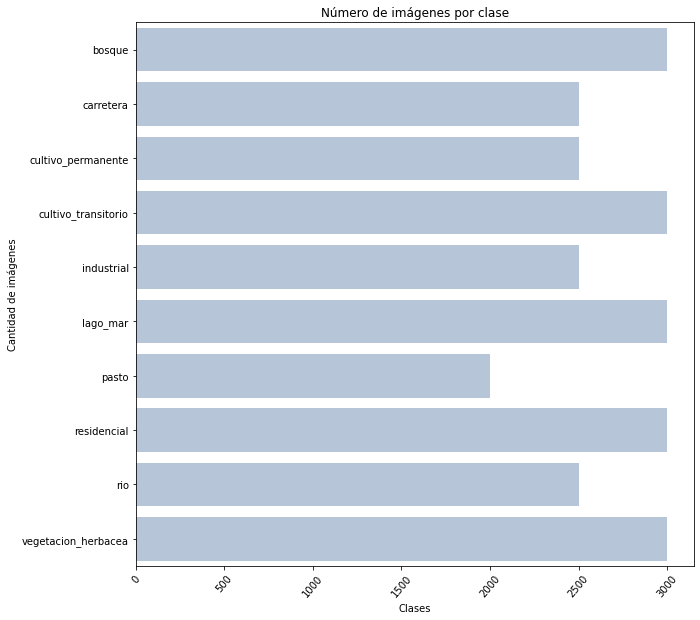

In [4]:
vi.visualize_countplot(folders, len_values, xlabel="Clases", ylabel="Cantidad de imágenes", title="Número de imágenes por clase", jpgname="n_files_per_folder")

In [13]:
#Los márgenes de distribución de imágenes por carpeta se presentan perceptiblemente homogéneos y aceptables, ya que proporcionalmente no hay mucha diferencia entre la cantidad máxima y mínima de impresiones. Por lo tanto, se decide no hacer data augmentation para este proyecto, ya que el margen de mejora, con tal cantidad de imágenes, y tanta homogeneidad entre los distintos labels, es bajo.

In [14]:
#Ahora que los datos han sido revisados y limpiados, se procede a organizarlos en sus correspondientes carpetas. 
#Primero se crean directorios con los mismos nombres que en downloads, pero en la sección data/test.

#AVISO: Esta celda solo tiene que ser ejecutada una única vez. En este caso de trabajo, ya ha sido ejecutada, por lo que no se recomienda volver a ejecutar para su óptima visualización. Si se vuelve a ejecutar, dará lugar a un error que no interferirá en los resultados ya que la función no hará ningun cambio sobre el contenido con el que se trabaja.

fol.create_test_train_folders(ds_dir)

Directorio bosque creado
Directorio carretera creado
Directorio cultivo_permanente creado
Directorio cultivo_transitorio creado
Directorio industrial creado
Directorio lago_mar creado
Directorio pasto creado
Directorio residencial creado
Directorio rio creado
Directorio vegetacion_herbacea creado
Directorio bosque creado
Directorio carretera creado
Directorio cultivo_permanente creado
Directorio cultivo_transitorio creado
Directorio industrial creado
Directorio lago_mar creado
Directorio pasto creado
Directorio residencial creado
Directorio rio creado
Directorio vegetacion_herbacea creado


In [15]:
#Segundo, se va a extraer del total de las carpetas un 20% de su contenido para utilizarlo como test y se integrarán en los correspondientes directorios creados previamente.

#AVISO: Esta celda solo tiene que ser ejecutada una única vez. En este caso de trabajo, ya ha sido ejecutada, por lo que no se recomienda volver a ejecutar para su óptima visualización.

fol.split_files(n=10,ds_dir=ds_dir)

Archivos de test de bosque correctamente transportados
Archivos de train de bosque correctamente transportados
Archivos de test de carretera correctamente transportados
Archivos de train de carretera correctamente transportados
Archivos de test de cultivo_permanente correctamente transportados
Archivos de train de cultivo_permanente correctamente transportados
Archivos de test de cultivo_transitorio correctamente transportados
Archivos de train de cultivo_transitorio correctamente transportados
Archivos de test de industrial correctamente transportados
Archivos de train de industrial correctamente transportados
Archivos de test de lago_mar correctamente transportados
Archivos de train de lago_mar correctamente transportados
Archivos de test de pasto correctamente transportados
Archivos de train de pasto correctamente transportados
Archivos de test de residencial correctamente transportados
Archivos de train de residencial correctamente transportados
Archivos de test de rio correctament

## Partición de train, test y validación

In [6]:
#Con las imágenes ya organizadas, se genera un conjunto de test (10%) y uno de entrenamiento con validación (20%). Es muy importante quitarle el shuffle de creación a test_ds ya que sino dará errores en las predicciones.

train_ds, val_ds, test_ds = mo.train_val_split_from_dir()

Conjunto de entrenamiento:
Found 24300 files belonging to 10 classes.
Using 19440 files for training.

Conjunto de validación:
Found 24300 files belonging to 10 classes.
Using 4860 files for validation.

Conjunto de test:
Found 2700 files belonging to 10 classes.


In [12]:
#Como se muestra a contiuación, "train_ds" es un Dataset de tensorflow con 32 de batchsize.
train_ds

<BatchDataset shapes: ((None, 64, 64, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [13]:
#Igual que se cogió el directorio del dataset una vez descargado para procesar (ds_dir), se coge el directorio del dataset de entrenamiento. Y también se coje las carpetas que se encuentran en train y que definen los labels con los que se va a entrenar.

train_dir = ".." + os.sep + "data" + os.sep + "train"
train_labels = os.listdir(train_dir) 

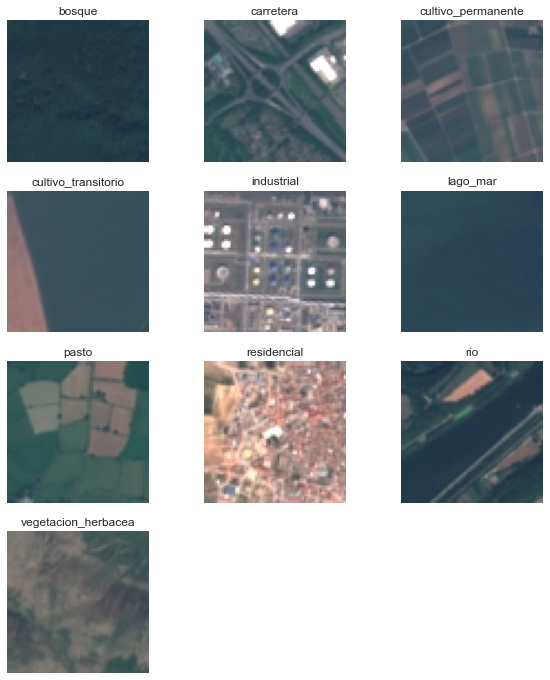

In [14]:
#Se visualiza la data con la librería matplotlib.pyplot. En este caso, como tardaría mucho en reproducir todos los valores y sus clases, se coge 1 valor de cada clase para poder identificar como se trabajan las imágenes con sus respectivas clases.

vi.imageset_intro_vis(train_labels, ds_path=train_dir)

In [17]:
#A ojo humano, las imágenes corresponden con la clasificación de training.

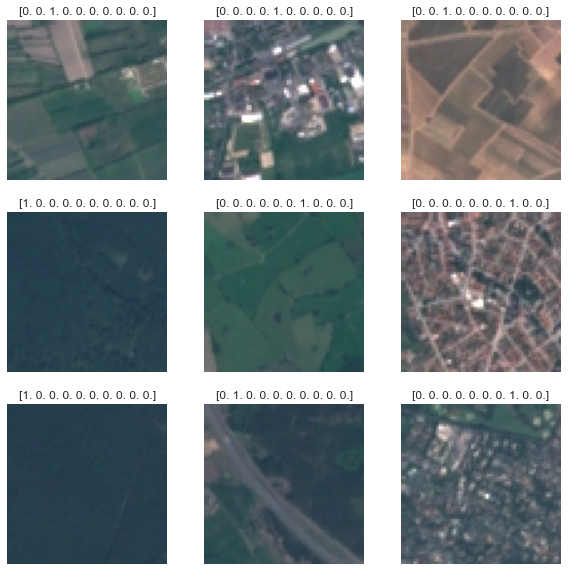

In [15]:
#Con tensorflow, se guardan dichas clases como labels en arrays de 10 de longitud con formato 'one-hot encoding', correspondiendo a las 10 clases que habían originalmente. En este paso, se muestra como cada imágen se corresponde con un label (target) particular.

vi.labels_intro_vis(download_folders=os.listdir(train_dir), training=train_ds)

## Diseño de modelos de Machine y Deep Learning

In [16]:
#Ahora que la data está organizada y se han establecido los conjuntos de train y validation, se procede a la creación de modelos. 

#Este proyecto trabaja con clasificación y segmentación de imágenes obtenidas por visión artificial, por este motivo se pondrán a prueba modelos de red neuronal convolucional (CNN).

#El primer paso para el modelo, es reescalar los valores de color a 0-1. Esto se debe a que los modelos de convolución de neuronas trabajan mejor con valores que se encuentran en este intervalo, y la gama cromática "rgb" ofrece valores del 1 al 255. Por este motivo, y para no afectar al BatchDataset, se aplica primero una capa de reescalado de los valores de color.

cnn_model_1 = keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1.0 / 255),
    layers.Conv2D(64, (3, 3), padding="same",input_shape=(64, 64, 1),activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation="softmax")
])

In [17]:
#A continuación, se estipulan los parámetros de compilación para el modelo que se entrena. Estos parámetros son uniformes para los distintos modelos de red neuronal convolucional que se van a estudiar, ya que, están adecuados al tipo de red que se pretenden trabajar y a los resultados que se quieren obtener.

#Optimizer: de inicio se prueba con el optimizador adam, que es una de los optimizadores más populares que ofrece keras, y se probarán también otros algorítmos para los distintos modelos.

#Loss: se utiliza el "categorical_crossentropy" porque se trabaja con más de 2 "labels" y con formato "one-hot encoder", es decir, con arrays de 0 y 1.

#Metrics: se aplica "accuracy" o precisión porque mide la capacidad del modelo de acertar, en porcentaje, y nos otorga un resultado de éxito.

cnn_model_1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
#Se aplica un callback de "EarlyStopping" para evitar que un exceso de repetición de épocas resulte en overfitting. Como tampoco se le da un número muy elevado de épocas, por conveniencia del tiempo de trabajo disponible en el proyecto, la paciencia asignada a este "EarlyStopping" será de 3. También, se habilita el parámetro de "restore_best_weights" para recoger el número de épocas en que el modelo ha sido mejor entrenado entre las 3 últimas épocas que estipula la paciencia. Este callback, será utilizado para todos los modelos de entrenamiento.

callback = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [19]:
#Se entrena el modelo
history_1 = cnn_model_1.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=[callback])

Epoch 1/30
608/608 [==============================] - 59s 97ms/step - loss: 1.4334 - accuracy: 0.4724 - val_loss: 1.0742 - val_accuracy: 0.6142
Epoch 2/30
608/608 [==============================] - 56s 92ms/step - loss: 1.0109 - accuracy: 0.6300 - val_loss: 0.9225 - val_accuracy: 0.6728
Epoch 3/30
608/608 [==============================] - 56s 92ms/step - loss: 0.8451 - accuracy: 0.6956 - val_loss: 0.8334 - val_accuracy: 0.6932
Epoch 4/30
608/608 [==============================] - 56s 92ms/step - loss: 0.7750 - accuracy: 0.7191 - val_loss: 0.8552 - val_accuracy: 0.7035
Epoch 5/30
608/608 [==============================] - 56s 92ms/step - loss: 0.6888 - accuracy: 0.7551 - val_loss: 0.7374 - val_accuracy: 0.7372
Epoch 6/30
608/608 [==============================] - 56s 92ms/step - loss: 0.6363 - accuracy: 0.7739 - val_loss: 0.7282 - val_accuracy: 0.7428
Epoch 7/30
608/608 [==============================] - 56s 92ms/step - loss: 0.5939 - accuracy: 0.7894 - val_loss: 0.6846 - val_accuracy:

In [ ]:
history_2 = cnn_model_2.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=[callback])

In [20]:
#Con la función summary, se muestra un esquema de la red neuronal que se ha creado.

cnn_model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               8388736   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

In [119]:
#Se evalua el modelo con el conjunto de test. Como se observa, se ha cogido el mejor número de épocas para el modelo.

acc_model_1, loss_model_1 = cnn_model_1.evaluate(test_ds)

85/85 [==============================] - 2s 23ms/step - loss: 0.5711 - accuracy: 0.7996


## Visualizaciones para el modelo con mayor precisión

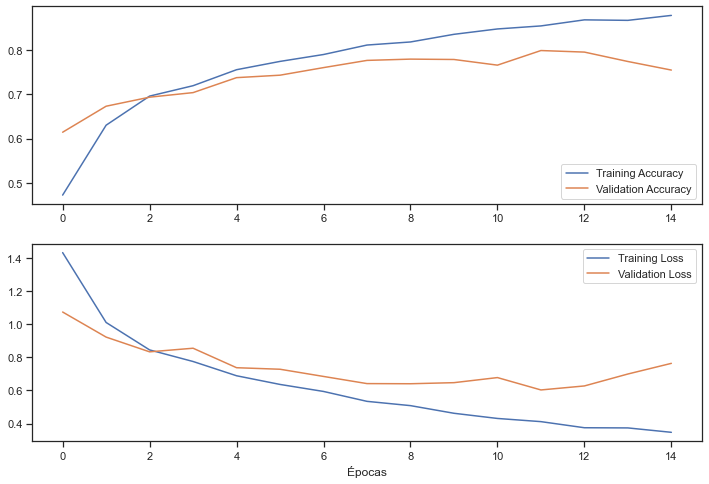

In [22]:
#Se muestra por pantalla una visualización de la evolución de la precisión y del loss, de entrenamiento y validación, a lo largo de las épocas del mejor modelo.

vi.accuracy_evolution_vis(model_history = history_1)

In [7]:
#Una vez ya visualizado como ha evolucionado el modelo en el entrenamiento, se procede a trabajar con las predicciones. Para ello, como se está trabajando con un modelo de clasificación "multilabel", se elabora una matriz de confusión.

matrix, y_true, y_pred = mo.generate_confusion_matrix(test_ds, cnn_model_1)

[[284   0   0   0   0   1  11   0   1   3]
 [  2 170   5   8  17   0   1  17  19  11]
 [  0  40 101  14   6   0   0   9   4  76]
 [  3  10   8 241   1   7   4   0  14  12]
 [  0   1   0   0 235   0   0  14   0   0]
 [ 21   1   0   3   0 262   9   0   3   1]
 [  6  15  10   0   0   0 158   0   3   8]
 [  0   4   1   0  27   0   0 265   0   3]
 [  8  54   1   7   0   0   9   2 164   5]
 [  5  16  10   4   7   2   5  16   5 230]]


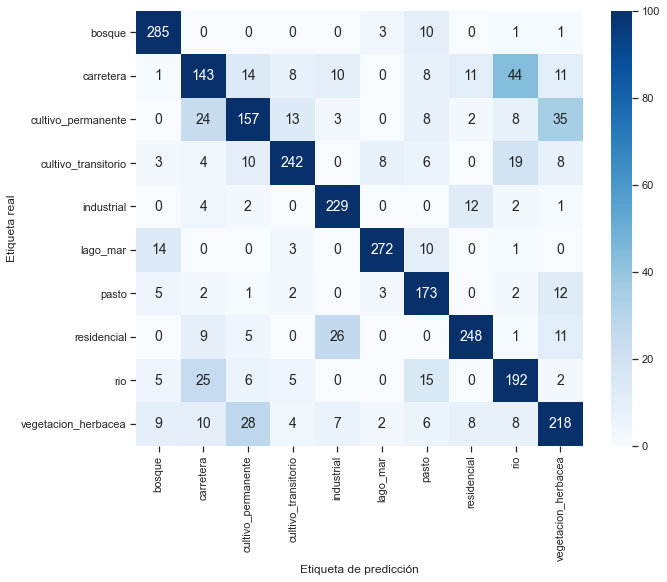

In [25]:
#Para una mejor visualización de la matriz, se utiliza un heatmap de seaborn y se sacan las conclusiones pertinentes. A simple vista, se puede observar que carretera y cultivo permanente son las clases peor identificadas. Si bien, no hay el mismo número de imágenes por clase para hacer una afirmación directa sobre el porcentaje de imágenes identificadas, tampoco se puede negar que, siendo cultivo permanente y carretera los que menos aciertos (true positives) tengan un mayor número de imágenes no identificadas.
vi.plot_confusion_matrix(matrix, os.listdir(train_dir))

In [57]:
#Para definir mejor los resultados, utilizamos las métricas de precisión, recall y f1-score

#La precisión marca que casos de predicción positiva son acertados. Compara los verdaderos positivos con los falsos positivos. Es decir, Es el parámetro que mide la calidad para detectar la zona especificada. El parametro 'acc' dice la probabilidad de que sea verdadera la predicción que se haga para la clase de imagenes concreta.

#La métrica de recall o exhaustividad informa sobre la cantidad, en porcentaje, de imagenes por clase, el modelo de machine learning es capaz de identificar. 

#El score muestra el rendimiento combinado de precisión y recall. Muestra la eficacia que tiene el programa para trabajar con esa clase.

#Con la función classification_report() de sklearn se pueden obtener las métricas de precisión, recall y f1-score de cada clase. Es importante activar el parámetro de output_dict para extraerlo como diccionario, hacer un dataframe y hacer la visualización pertinente después.

dict_report = classification_report(y_true, y_pred, target_names=os.listdir(train_dir), output_dict=True)
print(dict_report)

{'bosque': {'precision': 0.8850931677018633, 'recall': 0.95, 'f1-score': 0.9163987138263665, 'support': 300}, 'carretera': {'precision': 0.6470588235294118, 'recall': 0.572, 'f1-score': 0.6072186836518046, 'support': 250}, 'cultivo_permanente': {'precision': 0.7040358744394619, 'recall': 0.628, 'f1-score': 0.6638477801268499, 'support': 250}, 'cultivo_transitorio': {'precision': 0.8736462093862816, 'recall': 0.8066666666666666, 'f1-score': 0.8388214904679376, 'support': 300}, 'industrial': {'precision': 0.8327272727272728, 'recall': 0.916, 'f1-score': 0.8723809523809524, 'support': 250}, 'lago_mar': {'precision': 0.9444444444444444, 'recall': 0.9066666666666666, 'f1-score': 0.9251700680272109, 'support': 300}, 'pasto': {'precision': 0.7330508474576272, 'recall': 0.865, 'f1-score': 0.7935779816513762, 'support': 200}, 'residencial': {'precision': 0.8825622775800712, 'recall': 0.8266666666666667, 'f1-score': 0.8537005163511188, 'support': 300}, 'rio': {'precision': 0.6906474820143885, 'r

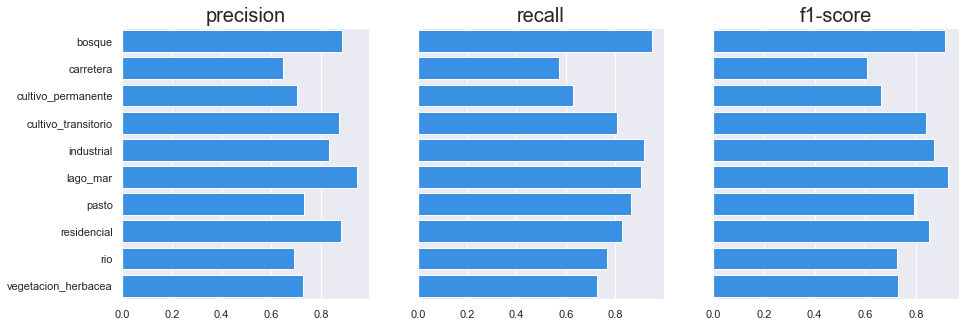

In [118]:
#En esta celda, se procede a crear el dataframe a partir de los datos que nos da la función de classification_report y la visualización de los mismo en barplots. Como se puede observar. Las imágenes con formas longitudinales y paralelas como rio y carretera son de las que menos precisión tienen, sin embargo, como no tiene que haber necesariamente una correlación directa para los resultados de recall, se ve como algunos valores incrementan su % en recall mientras que otros lo disminuyen. Si se toma el caso de carretera y rio, se ve como ambos presentan una precisión muy similar, pero en recall se distancian completamente. Esto se debe a que cuando el modelo afirma que una imágen es río o es carretera, la probabilidad de que esté en lo cierto, es la misma. No obstante, recall indica que porcentaje de imágenes ha logrado obtener, esto informa de que el modelo ha predicho en mayor cantidad imagenes de río, y por lo tanto, ha clasificado una mayor cantidad de imagenes para esta clase.

#En score, tomando ese valor como el más esclarecedor, bosque y lago_mar, las clases con imágenes más homogeneas a vista humana, son las que mejor ha logrado identificar. Mientras que, carretera y cultivo_permanente, han sido las clases más dificultosas de organizar para el modelo.

def clas_dict_to_data_vis(report):
    """Esta función, a partir de un reporte en formato de diccionario. Genera un dataframe que retorna y crea una visualización para los datos del reporte"""

    df = pd.DataFrame(report).T[:-3]
    df.drop(df.columns[-1], axis=1, inplace=True)

    fig, axes = plt.subplots(1, 3, sharey=True, figsize=(15,5))

    for i, k in enumerate(df.columns):
        axes[i].set_title(k, fontsize=20)
        sns.barplot(y=df.index, x=df[k].values,data=df, color="dodgerblue", ax=axes[i])


    plt.savefig(".." + os.sep + "reports" + os.sep + "from_main" + os.sep + "images" + os.sep + "classification_report.jpg")
    plt.show()
            
    return df

prediction_scores = clas_dict_to_data_vis(dict_report)

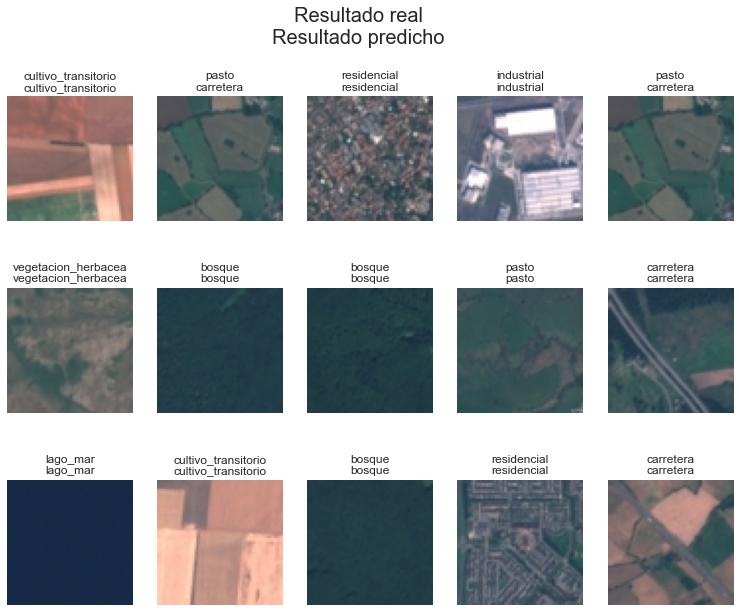

In [146]:
#Para ejemplificar como el modelo las está reconociendo, se genera una visualización de un conjunto de imágenes cogido con la libreria random sobre el conjunto de test y de predicción y se muestra por pantalla.

vi.real_pred_samples(test_ds, predicted_categories, cnn_model_1)

In [32]:
#Se guarda el modelo en la carpeta principal "models"

mo.save_model(path=".." + os.sep + "models" + os.sep, model=cnn_model_1, model_filename="model1.h5")

El modelo ha sido guardado correctamente


In [6]:
#También se guarda en models en formato carpeta para utilizar con streamlit

tf.saved_model.save(cnn_model_1, ".." + os.sep + "models" + os.sep + "model1.pb")


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: ..\models\model1.pb\assets


In [4]:
#Se guarda su arquitectura también en formato json.

json_config = cnn_model_1.to_json()

In [ ]:
#Y se guarda como archivo físico en la carpeta models

fol.create_json_from_dict(path_file=".." + os.sep + "models" + os.sep + "model1.json", dict=json_config)

In [43]:
cnn_model_2 = keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1.0 / 255),
    layers.Conv2D(64, kernel_size=(3, 3), input_shape=(64, 64, 1), padding='same'),
    layers.Dropout(0.2),
    layers.MaxPooling2D(pool_size=(3, 3), padding="same"),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dense(10)
])

In [46]:
cnn_model_2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [47]:
history_2 = cnn_model_2.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=[callback])

Epoch 1/30
608/608 [==============================] - 80s 132ms/step - loss: 8.2112 - accuracy: 0.0917 - val_loss: 7.8501 - val_accuracy: 0.0977
Epoch 2/30
608/608 [==============================] - 79s 129ms/step - loss: 8.2133 - accuracy: 0.0913 - val_loss: 7.8501 - val_accuracy: 0.0977
Epoch 3/30
608/608 [==============================] - 78s 128ms/step - loss: 8.1809 - accuracy: 0.0913 - val_loss: 7.8501 - val_accuracy: 0.0977
Epoch 4/30
608/608 [==============================] - 78s 128ms/step - loss: 8.2390 - accuracy: 0.0913 - val_loss: 7.8501 - val_accuracy: 0.0977
Epoch 5/30
608/608 [==============================] - 78s 128ms/step - loss: 8.0831 - accuracy: 0.0913 - val_loss: 7.8501 - val_accuracy: 0.0977
Epoch 6/30
608/608 [==============================] - 79s 130ms/step - loss: 8.1196 - accuracy: 0.0913 - val_loss: 7.8501 - val_accuracy: 0.0977


## Cargas de modelo

Esta sección es de uso exclusivo a aquellos usuarios que quieran utilizar el modelo guardado y no volver a generar otro modelo entrenado para hacer predicciones

In [3]:
cnn_model_1 = mo.load_model(path= ".." + os.sep + "models" + os.sep + "model1.h5")

In [ ]:
cnn_model_2 = mo.load_model(path= ".." + os.sep + "models" + os.sep + "model2.h5")

In [ ]:
model_3 = mo.load_model(path= ".." + os.sep + "models" + os.sep + "model3.h5")

In [ ]:
model_4 = mo.load_model(path= ".." + os.sep + "models" + os.sep + "model4.h5")

In [ ]:
model_5 = mo.load_model(path= ".." + os.sep + "models" + os.sep + "model5.h5")

In [23]:
#Se guarda una segunda copia .json en otra ruta para trabajar en el notebook.
fol.create_json(".." + os.sep + "reports" + os.sep + "from_main" + os.sep + "cleaned_data.json", data)

In [24]:
#Se sube una copia del dataframe al servidor de MySQL propuesto para el proyecto. Primero, se establece la conexión con el servidor, que vendrá apoyada con la funcionalidad del módulo mysql_tb en la que se encuentra la clase MYSQL.
db_connection = connect_mysql(IP_DNS="54.87.229.244", USER="21755015m", PASSWORD="adriagallardo96", BD_NAME="21755015m_ds_april_2021_db", PORT=25001)

Connected to MySQL server [21755015m_ds_april_2021_db]


In [25]:
#Por consiguiente, se sube el DataFrame al servidor.
data.to_sql(name="21755015m_ds_april_2021_db_tb", con=db_connection, if_exists="replace", index=False)

In [26]:
#Finalmente, se comprueba que se haya subido correctamente con una lectura del DataFrame

pd.read_sql_table("21755015m_ds_april_2021_db_tb", db_connection)

,sex,age,address,famsize,Pstatus,Medu,Fedu,reason,guardian,traveltime,...,nursery,higher,internet,romantic,famrel,freetime,goout,absences,alcohol,grade
0,F,18,U,GT3,A,4,4,course,mother,2,...,yes,yes,no,no,4,3,4,6,2,17
1,F,17,U,GT3,T,1,1,course,father,1,...,no,yes,yes,no,5,3,3,4,2,16
2,F,15,U,LE3,T,1,1,other,mother,1,...,yes,yes,yes,no,4,3,2,10,5,25
3,F,15,U,GT3,T,4,2,home,mother,1,...,yes,yes,yes,yes,3,2,2,2,2,44
4,F,16,U,GT3,T,3,3,home,father,1,...,yes,yes,no,no,4,3,2,4,3,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010,F,19,R,GT3,T,2,3,course,mother,1,...,no,yes,yes,no,5,4,2,4,3,31
1011,F,18,U,LE3,T,3,1,course,mother,1,...,yes,yes,yes,no,4,3,4,4,2,46
1012,F,18,U,GT3,T,1,1,course,mother,2,...,yes,yes,no,no,1,1,1,6,2,32
1013,M,17,U,LE3,T,3,1,course,mother,2,...,no,yes,yes,no,2,4,5,6,7,30
